# Overall Performance, including on empty images
---
Up until now, all the focus was on the precision of the multi-class classifier on data where we knew there were animals present.  The overall performance, and practical case use depends on the models ability to reject empty images.  I haven't got time to integrate this into the main eval notebook right now, but will create a seperate notebook for the purpose.  

The detector will need to be run seperately first on the 'Empty_Images' folder to generate the results file needed by this notebook

In [1]:
import torch
import numpy as np
import random
import ast
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import warnings
%matplotlib inline
import os
import json
import yaml
import pandas as pd
import sys
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score
import seaborn as sns
import importlib
import Inference
import cv2
importlib.reload(Inference)

<module 'Inference' from 'e:\\Project\\Python\\Inference.py'>

In [2]:
TEMP_SETTINGS_PATH = r'E:\Project\Settings\Current\Exp_26_Experiments.yaml'  #Replace with None to use the defaults below

In [3]:
class DefaultConfig:
    def __init__(self):
        self.EXPERIMENT_NAME = 'Exp_26'
        self.RUN_ID = 'Run_02'
        self.DESCRIPTION = 'Evaluating Some Experiment'
        self.DATA_FOLDER_NM = 'Data'
        self.EXPS_FOLDER_NM = 'Experiments'
        self.INPUT_FOLDER_NM = 'Inputs'
        self.CROP_LABELS_NM = 'crop_labels.parquet'
        self.RUNS_FOLDER_NM = 'Runs'
        self.SETTINGS_FOLDER_NM = 'Settings'
        self.RESULTS_FOLDER_NM = 'Results'  # Increment or name this to name the results folder
        self.MODELS_FOLDER_NM = 'Models'
        self.WEIGHTS_FOLDER_SUFFIX = '_weights'
        self.IMAGE_FOLDER_NM = 'Cropped_Images'
        self.DEFAULT_IMAGE_FOLDER_NM = 'Independent_Images'
        self.EMPTY_IMAGE_FOLDER_NM = 'Empty_Images'
        self.TEST_SPLIT_PARQUET_NM = '_test_split.parquet'
        self.TRAINING_METRICS_NM = '_monitor_train.png'
        self.WEIGHTS_FN_SUFFIX = '_best_weights.pt'
        self.RESULTS_DF_SUFFIX = '_df.pkl'
        self.CLASS_NAMES = '_class_names.json'
        self.CLASS_ACCURACY_OUT = '_accuracy_by_class.csv'
        self.CF_MATRIX_SUFFIX_OUT = '_confusion_matrix.csv'
        self.CF_MATRIX_NORM_SUFFIX_OUT = '_confusion_matrix_norm.csv'
        self.CF_MATRIX_FIG_SUFFIX_OUT = '_confusion_matrix.png'
        self.TEST_PREDICTIONS_SUFFIX_OUT = '_test_predictions.parquet'
        self.PREDS_PARQUET_SUFFIX_OUT = '_infer_predictions.parquet'
        self.BAL_IND_PREDICTIONS = '_balanced_preds.csv'
        self.SETUP_FOLDER_NM = 'Setup'
        self.PERFORMANCE_LOG = 'Performance_Monitor.csv'
        self.BATCH_SIZE = 64
        self.CROP_SIZE = 600
        self.BUFFER = 0
        self.RESCALE = True
        self.EDGE_FADE = False
        self.MIN_FADE_MARGIN = 0.05
        self.MAX_FADE_MARGIN = 0.05
        self.MODEL_NAME = 'tf_efficientnetv2_l.in21k_ft_in1k'
        self.HEAD_NAME = 'ClassifierHead' # Alternative: BasicHead
        self.INDEPENDENT_TEST_ONLY = ['N01', 'BWS', 'EBF', 'EM1', 'ES1']
        self.TO_MONITOR = ['cat', 'mouse', 'possum', 'rat', 'stoat']
        self.CLASSES_TO_EXCLUDE=  ['shag', 'moth', 'skink', 'lizard', 'fernberd', 'skylark', 'grey_duck', 'long_tailed_cuckoo']
        self.CLASSES_TO_IGNORE = [] #still train with images and detect, but assign to 'unknown' eg [penguin], A penguin and kea walk into a bar, the detector only pays attention to the kea, since the penguin is 'unknown'
        self.CLASS_JOINS =  {'lizard':['skink', 'lizard'], 'finch':['greenfinch', 'goldfinnch', 'chaffinch'], 'quail':['quail_california', 'quail_brown']} 
        self.CLASS_NAME_CHANGE = {'penguin':'little_blue_penguin', 'song thrush':'thrush', 'NZ_falcon':'nz_falcon'} # Folders labelled the first thing are re-labeled the second thing
        self.DEBUG = False  #Remember to change back to false after debugging!

def get_settings_path():
    '''Access a temporary .json file created to pass the settings file path from a master python script to a notebook, then delete
    intended only to access a specific file once from the master script'''
    script_dir = Path(os.path.abspath(''))
    json_pth = script_dir / 'temp_settings_path.json'
    try:
        with open(json_pth, 'r') as json_file:
            json_data = json.load(json_file)
            settings_path = Path(json_data['settings_path'])
            if not settings_path:
                print('No settings path was found in "temp_settings_path.json"')
                sys.exit()
    except:  #if running stand-alone
        if TEMP_SETTINGS_PATH:
            settings_path = Path(TEMP_SETTINGS_PATH)
    if json_pth.exists():
        print(f'Deleting the json file from {json_pth}')
        json_pth.unlink()
    return settings_path

def get_config(settings_pth = None):
    '''#if cfg.Debug, looks for temp settings, otherwise uses settings_path, otherwise uses DefaultConfig'''
    #Attributes with values that need evaluating from strings, e.g. '1e-5', singletons, instances:
    evaluate_list = ['CLASSES', 'CLASSES_TO_EXCLUDE', 'CLASSES_TO_IGNORE', 'CLASS_JOINS', 'CLASS_NAME_CHANGE', 
                     'LOCATIONS_TO_EXCLUDE', 'LOCATIONS_FOR_TEST_ONLY', 'DEBUG', 'EDGE_FADE']
    cfg = DefaultConfig()
    project_dir = Path(os.path.abspath('')).parent
    
    if cfg.DEBUG:
        settings_fldr = project_dir / cfg.SETTINGS_FOLDER_NM / 'Debug'
        settings_paths = list(settings_fldr.glob("*.yaml"))
        sorted_paths = sorted(settings_paths, key=lambda x: os.path.getmtime(x), reverse=True)
        settings_pth = sorted_paths[0] if sorted_paths else None
    
        if not settings_pth:
            print('No settings.yaml file has been found, please ensure at least one is present in the debug folder')
            sys.exit(1)  # Use an exit code of 1 to indicate an error
    
    if settings_pth:
        with open(settings_pth, 'r') as yaml_file:
            yaml_data = yaml.load(yaml_file, Loader=yaml.FullLoader)
        for key, value in yaml_data.items():
            if hasattr(cfg, key):
                if (key in evaluate_list) and (isinstance(value, str)):
                    setattr(cfg, key, eval(value))
                else:
                    setattr(cfg, key, value)
    return cfg

settings_pth = get_settings_path()
cfg = get_config(settings_pth)

class Colour:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
print(Colour.S + f'Evaluating experiment {cfg.EXPERIMENT_NAME}, run: {cfg.RUN_ID}' + Colour.E)
if settings_pth:
    print(Colour.S + f'Using settings from {settings_pth}' + Colour.E)
    print(Colour.S + 'Experiment & run description: '+ Colour.E, cfg.DESCRIPTION)
else:
    print(Colour.S +'Using default configuration from this notebook' + Colour.E)

Evaluating experiment Exp_26, run: Run_01
Using settings from E:\Project\Settings\Current\Exp_26_Experiments.yaml
Experiment & run description:  Camera-Class Limit 200, random, Fine-tune, update crops


In [4]:
INPUT_MEAN = [ 0.485, 0.456, 0.406 ] # mean to be used for normalisation, using values from ImageNet.
INPUT_STD = [ 0.229, 0.224, 0.225 ] # stddev to be used for normalisation, using values from ImageNet.

project_dir = Path(os.path.abspath('')).parent
experiment_dir = project_dir / cfg.DATA_FOLDER_NM / cfg.EXPS_FOLDER_NM / cfg.EXPERIMENT_NAME
results_dir = experiment_dir / cfg.RUNS_FOLDER_NM / cfg.RUN_ID / cfg.RESULTS_FOLDER_NM 
models_dir = experiment_dir / cfg.RUNS_FOLDER_NM / cfg.RUN_ID / cfg.MODELS_FOLDER_NM
test_parquet_path = results_dir / f'{cfg.RUN_ID}{cfg.TEST_SPLIT_PARQUET_NM}'
out_parquet_path = results_dir /  f'{cfg.RUN_ID}{cfg.PREDS_PARQUET_SUFFIX_OUT}'
balanced_preds_path = results_dir /  f'{cfg.RUN_ID}{cfg.BAL_IND_PREDICTIONS}'

weights_pth = models_dir / f'{cfg.RUN_ID}{cfg.WEIGHTS_FOLDER_SUFFIX}' / f'{cfg.RUN_ID}{cfg.WEIGHTS_FN_SUFFIX}'
labels_pth = experiment_dir / cfg.INPUT_FOLDER_NM / cfg.CROP_LABELS_NM
image_dir = experiment_dir / cfg.IMAGE_FOLDER_NM
independent_image_dir = project_dir / cfg.DATA_FOLDER_NM / cfg.DEFAULT_IMAGE_FOLDER_NM
empty_image_dir = project_dir / cfg.DATA_FOLDER_NM / cfg.EMPTY_IMAGE_FOLDER_NM
train_metrics_pth = results_dir / f'{cfg.RUN_ID}{cfg.TRAINING_METRICS_NM}'
class_names_pth = results_dir / f'{cfg.RUN_ID}{cfg.CLASS_NAMES}'
pickle_paths = {'val_target_df': results_dir / f'{cfg.RUN_ID}_val_target{cfg.RESULTS_DF_SUFFIX}',
                'val_pred_df': results_dir / f'{cfg.RUN_ID}_val_pred{cfg.RESULTS_DF_SUFFIX}',
                'train_target_df': results_dir / f'{cfg.RUN_ID}_train_target{cfg.RESULTS_DF_SUFFIX}',
                'train_pred_df': results_dir / f'{cfg.RUN_ID}_train_pred{cfg.RESULTS_DF_SUFFIX}'}
cf_matrix_pth = results_dir / f'{cfg.RUN_ID}{cfg.CF_MATRIX_SUFFIX_OUT}'
cf_matrix_norm_pth = results_dir / f'{cfg.RUN_ID}{cfg.CF_MATRIX_NORM_SUFFIX_OUT}'
cf_matrix_fig_pth = results_dir / f'{cfg.RUN_ID}{cfg.CF_MATRIX_FIG_SUFFIX_OUT}'
cf_matrix_overall_pth = results_dir / f'{cfg.RUN_ID}_overall_cf_matrix.csv'
class_acc_pth = results_dir / f'{cfg.RUN_ID}{cfg.CLASS_ACCURACY_OUT}'
test_preds_pth = results_dir / f'{cfg.RUN_ID}_Test_Set_Inference{cfg.TEST_PREDICTIONS_SUFFIX_OUT}'
performance_log_pth = Path(os.path.abspath('')) / cfg.SETUP_FOLDER_NM / cfg.PERFORMANCE_LOG

print(Colour.S + f'Experiment: {cfg.EXPERIMENT_NAME}, Run {cfg.RUN_ID}' + Colour.E)
print(f'The project folder is located at {project_dir}')
print(f'The results folder is located at {results_dir}')
print(f'The test_split is located at {test_parquet_path}')
print(f'The model weights are located at {weights_pth}')
print(f'The model performance metrics will be logged to {performance_log_pth}')
print(f'The test images from unused locations will be located in {independent_image_dir}')
print(f'The empty test images will be located in {empty_image_dir}')

Experiment: Exp_26, Run Run_01
The project folder is located at e:\Project
The results folder is located at e:\Project\Data\Experiments\Exp_26\Runs\Run_01\Results
The test_split is located at e:\Project\Data\Experiments\Exp_26\Runs\Run_01\Results\Run_01_test_split.parquet
The model weights are located at e:\Project\Data\Experiments\Exp_26\Runs\Run_01\Models\Run_01_weights\Run_01_best_weights.pt
The model performance metrics will be logged to e:\Project\Python\Setup\Performance_Monitor.csv
The test images from unused locations will be located in e:\Project\Data\Independent_Images
The empty test images will be located in e:\Project\Data\Empty_Images


### Helper Functions

In [5]:
def remove_rare_classes(target_df, pred_df, rare_threshold):
    col_sums = target_df.sum(axis=0)
    original_width = target_df.shape[1]
    mask = col_sums >= rare_threshold

    remove_list=[]
    total_removed = 0
    for column_name, col_sum in col_sums.items():
        if col_sum < rare_threshold:
            remove_list.append((column_name,col_sum))
            total_removed +=col_sum
    
    remove_cols = original_width - mask.sum()
    target_df = target_df.loc[:, mask]
    pred_df = pred_df.loc[:, mask]  

    rows_to_remove = target_df.index[target_df.sum(axis=1) == 0]
    target_df = target_df.drop(rows_to_remove)
    pred_df = pred_df.drop(rows_to_remove)

    rows_with_targets = target_df.any(axis=1)
    target_df = target_df[rows_with_targets]
    pred_df = pred_df[rows_with_targets]

    if remove_cols > 0:
        print(f'From counting loop: Removing {len(remove_list)} species, {total_removed} instances: {remove_list}, ')
        print(f'Removing {remove_cols} classes as they have less than {rare_threshold} samples')
        print(f'Also removing {len(rows_to_remove)} image instances, as they were from those classes')
    return target_df, pred_df


def balance_data(df, parent_dir, num_class_place, class_total):
    def random_select(group, max_to_keep):
        n_rows = min(max_to_keep, len(group))
        return group.sample(n=n_rows)
    stem = str(parent_dir)
    df = df.copy()
    df['Place'] = [str(Path(x).relative_to(stem).parts[0]) if stem in x else '' for x in df.index]
    df['Place_Target'] = df['Place'] + '-' + df['Targets']
    df['File_Path'] = df.index
    df = df.groupby('Place_Target', group_keys=False).apply(random_select, num_class_place)
    df = df.groupby('Targets', group_keys=False).apply(random_select, class_total)
    df.reset_index(drop=True, inplace=True)
    keep_paths = df['File_Path'].to_list()
    return keep_paths


def data_from_json(data_pth):
    with open(data_pth, 'r') as f:
        data = json.load(f)
    return data

targets_list= data_from_json(class_names_pth)
targets_dict = {i: word for i, word in enumerate(targets_list)}

def load_image(image_path, mode):
    try:
        image = cv2.imread(image_path)
        if image is not None:
            if mode == 'RGB':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            return image
        else:
            print(f"Warning: Unable to load the image at '{image_path}'. Skipping...")
            return None
    except Exception as e:
        print(f"Warning: Unable to load the image at '{image_path}'. Error: {str(e)}. Skipping...")
    return None


def show_inferred_imgs(in_df, num_ims=9, rescale=cfg.RESCALE, crop_size=cfg.CROP_SIZE, buffer=cfg.BUFFER): 
    
    def pad_to_square(image):
        height, width, channels = image.shape
        size=max(height, width)
        dtype = image.dtype
        square_image = np.zeros((size, size, channels), dtype=dtype)
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2
        square_image[y_offset:y_offset+height, x_offset:x_offset+width] = image
        return square_image, x_offset, y_offset

    def get_new_scale(row, width, height, crop_size, buffer):
        """figures out how much to scale down the new image to, so the max(bounding-box) + buffer = the desired crop size
        only effects images where the crop box would be greater than the crop size"""
        clamp = lambda n: max(min(1, n), 0)
        x_min = clamp(row['x_min'] - buffer)
        y_min = clamp(row['y_min'] - buffer)
        x_max = clamp(row['x_min'] + row['Width'] + buffer)
        y_max = clamp(row['y_min'] + row['Height'] + buffer)
        max_dimension = max([(x_max - x_min)*width, (y_max - y_min)*height]) 
        return crop_size/max_dimension if max_dimension > crop_size else None
    
    num_cols = 3
    num_rows = int(np.ceil(num_ims/num_cols))
    file_paths = random.sample(in_df.index.tolist(), num_ims) #using file paths as the index for the df
    df = in_df.loc[file_paths]
    fig = plt.figure(figsize=(14, int(4*num_rows)))
    for idx in np.arange(num_ims):
        ax = fig.add_subplot(num_rows, num_cols,  idx+1, xticks=[], yticks=[])
        fp = file_paths[idx]
        row = df.loc[fp]
        target = row['Targets']
        prediction = row['Prediction']
        img = load_image(fp, mode='RGB')
        if img is not None:
            img_h, img_w, _ = img.shape
            if rescale:
                scale = get_new_scale(row, img_w, img_h, crop_size, buffer)
                if scale:
                    w, h = int(round(img_w * scale)), int(round(img_h * scale))
                    img = cv2.resize(img, (w, h), cv2.INTER_LANCZOS4)
                    img_h, img_w, _ = img.shape
            
            x_pad, y_pad = 0, 0
            img, x_pad, y_pad = pad_to_square(img)
            
            crop_list = ast.literal_eval(df.loc[fp]['Crop'])
            x_min, _, x_max, _ = [round(val*img_w) + x_pad for val in crop_list] # patches uses the same coordinate system as cv2 
            _ , y_min, _, y_max = [round(val*img_h)  + y_pad for val in crop_list]
            crop_w, crop_h = x_max - x_min, y_max - y_min
            meg_x_min =  round(df.loc[fp]['x_min']*img_w) + x_pad
            meg_y_min =  round(df.loc[fp]['y_min']*img_h) + y_pad
            meg_width =  round(df.loc[fp]['Width']*img_w)
            meg_height = round(df.loc[fp]['Height']*img_h)
            crop_rect = patches.Rectangle((x_min, y_min), crop_w, crop_h, linewidth=2, edgecolor='purple', facecolor='none')
            mega_rect = patches.Rectangle((meg_x_min, meg_y_min), meg_width, meg_height, linewidth=1, edgecolor='blue', facecolor='none')
            ax.imshow(img)
            ax.add_patch(crop_rect)
            ax.add_patch(mega_rect)
            if target == prediction:
                title = f'{prediction}'
                ax.title.set_color('green')
            else:
                title = f'{prediction} ({target})'
                ax.title.set_color('red')
            ax.set_title(title)
    return


def build_cf_matrix(targ_df, 
                    pred_df, 
                    cf_norm_pth=cf_matrix_norm_pth, 
                    cf_pth=cf_matrix_pth,
                    cf_fig_pth=cf_matrix_fig_pth):
    targ_df, pred_df = remove_rare_classes(targ_df, pred_df, 1)
    target_arr = targ_df.to_numpy()
    predicts_arr = pred_df.to_numpy()
    target_by_row = np.argmax(target_arr, axis=1)
    predict_by_row = np.argmax(predicts_arr, axis=1)
    cols = targ_df.columns
    target_names = [cols[idx] for idx in target_by_row]
    predict_names = [cols[idx] for idx in predict_by_row]
    classes = cols.tolist()
    cf_matrix_raw = confusion_matrix(target_names, predict_names)
    cf_matrix_norm = confusion_matrix(target_names, predict_names, normalize='true')
    df_cm_norm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
                              columns=[i for i in classes]).round(decimals=3)
    df_cm_raw = pd.DataFrame(cf_matrix_raw, index=[i for i in classes],
                             columns=[i for i in classes])
    df_cm_raw['Total Annotated'] = df_cm_raw[classes].sum(axis=1)
    plt.figure(figsize=(12, 11))
    ax_cm = sns.heatmap(df_cm_norm, annot=False, fmt='.1f')  # cmap="crest" for green/blue
    ax_cm.set(xlabel="Prediction", ylabel="Target")
    plt.savefig(cf_fig_pth)
    df_cm_raw.to_csv(cf_pth)
    df_cm_norm['Total Annotated'] = df_cm_norm[classes].sum(axis=1)
    df_cm_norm['Total Annotated'] = df_cm_norm['Total Annotated'].round(decimals=0)
    df_cm_norm.to_csv(cf_norm_pth)
    return

Create the dataset and model classes

## Setup

In [6]:
targets_list= data_from_json(class_names_pth)
print(f'There are {len(targets_list)} classes being classified')

There are 80 classes being classified


## Check the Input Data

In [7]:
print(Colour.S +'Class names for this model:' + Colour.E)
cum_chars = {item:len(item) for item in targets_list}

line_count=0
for animal in targets_list:
    print(animal, end='  ')
    line_count += len(animal)
    if line_count >= 80:
        line_count = 0
        print(' ')

Class names for this model:
banded_dotterel  banded_rail  bellbird  black_backed_gull  black_billed_gull  black_fronted_tern   
blackbird  canada_goose  cat  chamois  cow  crake  deer  dog  dunnock  fantail  ferret  finch  fluttering_shearwater   
goat  grey_faced_petrol  grey_warbler  hare  harrier  hedgehog  human  kaka  kea  kereru  kingfisher   
kiwi  little_blue_penguin  magpie  mallard  mohua  morepork  mouse  myna  nz_falcon  oystercatcher   
paradise_duck  parakeet  pateke  pheasant  pig  pipit  possum  pukeko  quail  rabbit  rat  redpoll  rifleman   
robin  rosella  sealion  sheep  shore_plover  silvereye  sparrow  spotted_dove  spurwing_plover  starling   
stilt  stoat  swallow  swan  takahe  thrush  tieke  tomtit  tui  wallaby  weasel  weka  white_faced_heron   
whitehead  wrybill  yellow_eyed_penguin  yellowhammer  

## Evaluating on an independent test set
The randomly selected test images evaluated earlier could potentially be correlated to the training data as they come from the same locations and so the background is the same.  This is a known challenge with trail cam image classification.  To get a more reliable performance assessment we have held some specific camera locations out of the training routine entirely.  The following test locations were used for this:

In [8]:
cfg.INDEPENDENT_TEST_ONLY

"['N01', 'BWS', 'EBF', 'EM1', 'ES1']"

The next cell runs the inference script, exactly as it would do in real use.  Cropping from large images with MegaDetector first.  The parquet file produced will be exactly the shape and classes defined in training and in the inference notebook (which must match in their default settings if not running from a common settings file).

However this script knows nothing about the class file names used for the test set, so those names will need to be cleaned and re-named as per the same settings to be useful for evaluation, prior to the one-hot encoding step which puts them into a dataframe.

In [9]:
importlib.reload(Inference)
inferred_df, speed = Inference.main(settings_pth, external_image_dir=independent_image_dir)
inferred_df.iloc[:,16].head()
cuda_data = torch.cuda.memory_allocated()
print(f'There is {cuda_data} Bytes allocated data left in the GPU memory after inference on the independent dataset')

json files found [WindowsPath('e:/Project/Data/Independent_Images/mdPredictions.json')]
The root path of the image folder is e:\Project\Data\Independent_Images
The dataframe length after processing e:\Project\Data\Independent_Images\mdPredictions.json: 10987
['blackbird' 'unknown' 'dog' 'dunnock' 'fantail' 'hare' 'kereru'
 'morepork' 'mouse' 'paradise_duck' 'robin' 'silvereye' 'thrush' 'tomtit'
 'cat' 'cow' 'deer' 'ferret' 'harrier' 'hedgehog' 'human' 'magpie' 'pipit'
 'possum' 'rabbit' 'stoat' 'weasel' 'yellowhammer' 'bellbird' 'goat' 'kea'
 'kiwi' 'pig' 'rat' 'rifleman' 'weka' 'banded_dotterel' 'tui']
Length of the labels dataframe: 10987
                                           File_Path  Mega_Class  Confidence  \
0  e:\Project\Data\Independent_Images\BWS\blackbi...           1       0.819   
1  e:\Project\Data\Independent_Images\BWS\blackbi...           1       0.927   
2  e:\Project\Data\Independent_Images\BWS\blackbi...           1       0.945   

    x_min   y_min    Width   H

100%|██████████| 95/95 [00:01<00:00, 83.08it/s]


The dataframe saved to CSV
                                                              Date_Time  \
Image_File_Paths                                                          
e:\Project\Data\Independent_Images\BWS\blackbir...  16/08/2020 16:50:58   
e:\Project\Data\Independent_Images\BWS\blackbir...  16/08/2020 16:50:59   
e:\Project\Data\Independent_Images\BWS\blackbir...  16/08/2020 16:50:59   
e:\Project\Data\Independent_Images\BWS\blackbir...  19/08/2020 08:36:29   
e:\Project\Data\Independent_Images\BWS\blackbir...  19/08/2020 08:36:29   

                                                    Encounter  Max_Prob  
Image_File_Paths                                                         
e:\Project\Data\Independent_Images\BWS\blackbir...  blackbird     0.982  
e:\Project\Data\Independent_Images\BWS\blackbir...  blackbird     0.982  
e:\Project\Data\Independent_Images\BWS\blackbir...  blackbird     0.982  
e:\Project\Data\Independent_Images\BWS\blackbir...  blackbird     0.890  
e:\

In [10]:
inferred_df.iloc[:,:17].head(1)

,Date_Time,Encounter_Start,Encounter,Max_Prob,Targets,Prediction,Probability,Second_Pred,Second_Prob,Third_Pred,Third_Prob,Crop,x_min,y_min,Width,Height,Confidence
Image_File_Paths,,,,,,,,,,,,,,,,,
e:\Project\Data\Independent_Images\BWS\blackbird\276676d2-40fd-4c26-93ae-d543fef8a90c.JPG,16/08/2020 16:50:58,16:50:58,blackbird,0.982,blackbird,blackbird,0.796,tieke,0.064,robin,0.04,"[0.8745, 0.2361, 0.9996, 0.4585]",0.875,0.287,0.125,0.12,0.868


In [11]:
inferred_df.iloc[:,17:].head(1)

,banded_dotterel,banded_rail,bellbird,black_backed_gull,black_billed_gull,black_fronted_tern,blackbird,canada_goose,cat,chamois,...,tui,wallaby,weasel,weka,white_faced_heron,whitehead,wrybill,yellow_eyed_penguin,yellowhammer,File_Path
Image_File_Paths,,,,,,,,,,,,,,,,,,,,,
e:\Project\Data\Independent_Images\BWS\blackbird\276676d2-40fd-4c26-93ae-d543fef8a90c.JPG,0.0,0.0,0.002,0.0,0.0,0.0,0.796,0.0,0.015,0.0,...,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e:\Project\Data\Independent_Images\BWS\blackbi...


In [12]:
print(f"There are {inferred_df['Targets'].nunique()} unique targets based on folder names")
print(f'There are {inferred_df.iloc[:,17:].shape[1]} unique targets in the model predictions')
print(f'There are {inferred_df.shape[0]} rows in the model output file')
all_classes = inferred_df['Targets'].unique()
targets_no_column = set(all_classes) - set(inferred_df.columns)
print(f'These are the targets that do not have a matching prediction class: {targets_no_column}')
for mystery_targ in targets_no_column:
    no_col_count = (inferred_df['Targets'] == mystery_targ).sum()
    print(f"There are {no_col_count} rows with the unmatched target of: {mystery_targ}")


There are 38 unique targets based on folder names
There are 81 unique targets in the model predictions
There are 10987 rows in the model output file
These are the targets that do not have a matching prediction class: {'unknown'}
There are 56 rows with the unmatched target of: unknown


In [13]:
def clean_independent_dataset(pred_df, cfg):
    original_shape = pred_df.shape
    to_drop = cfg.CLASSES_TO_IGNORE + cfg.CLASSES_TO_EXCLUDE
    pred_df = pred_df[~pred_df['Targets'].isin(to_drop)]
    # Get a dict to handle all name changes by merger
    flattened_list = [(key, value) for key, values in cfg.CLASS_JOINS.items() for value in values]
    inv_merge = {val:key for (key, val) in flattened_list}
    # Add the merger dict, to the name change dict, then do the name change
    rename_dict = cfg.CLASS_NAME_CHANGE.update(inv_merge)
    pred_df['Targets'] = pred_df['Targets'].replace(to_replace=rename_dict)
    # Remove any remaining classes that still don't correspond to a model column
    unique_targets = pred_df['Targets'].unique()
    targets_no_column = set(unique_targets) - set(inferred_df.columns)
    print(f'These are the targets that do not have a matching prediction class: {targets_no_column}')
    mystery_total = 0
    for mystery_targ in targets_no_column:
        no_col_count = (inferred_df['Targets'] == mystery_targ).sum()
        mystery_total += no_col_count
        print(f"There are {no_col_count} rows with the unmatched target of: {mystery_targ}")
    if mystery_targ:
        print(f'{mystery_total} rows with targets correstponding to missing classes have been removed')
    pred_df = pred_df[~pred_df['Targets'].isin(targets_no_column)]
    
    print(f'The original shape was {original_shape}, and the final shape was {pred_df.shape}')
    return pred_df

cleaned_inf_df = clean_independent_dataset(inferred_df, cfg)

These are the targets that do not have a matching prediction class: {'unknown'}
There are 56 rows with the unmatched target of: unknown
56 rows with targets correstponding to missing classes have been removed
The original shape was (10987, 98), and the final shape was (10931, 98)


In [14]:
print(f"There are {cleaned_inf_df.Targets.nunique()} unique classes in the independent test set, from {cleaned_inf_df.shape[0]} images")

There are 37 unique classes in the independent test set, from 10931 images


In [15]:
cleaned_inf_df.head(3)

,Date_Time,Encounter_Start,Encounter,Max_Prob,Targets,Prediction,Probability,Second_Pred,Second_Prob,Third_Pred,...,tui,wallaby,weasel,weka,white_faced_heron,whitehead,wrybill,yellow_eyed_penguin,yellowhammer,File_Path
Image_File_Paths,,,,,,,,,,,,,,,,,,,,,
e:\Project\Data\Independent_Images\BWS\blackbird\276676d2-40fd-4c26-93ae-d543fef8a90c.JPG,16/08/2020 16:50:58,16:50:58,blackbird,0.982,blackbird,blackbird,0.796,tieke,0.064,robin,...,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e:\Project\Data\Independent_Images\BWS\blackbi...
e:\Project\Data\Independent_Images\BWS\blackbird\03cdd9a8-24ee-4979-98aa-96fdc84009e3.JPG,16/08/2020 16:50:59,16:50:58,blackbird,0.982,blackbird,blackbird,0.959,robin,0.026,kereru,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e:\Project\Data\Independent_Images\BWS\blackbi...
e:\Project\Data\Independent_Images\BWS\blackbird\1d42a65f-233d-48c2-b92b-b3ddfd0380d3.JPG,16/08/2020 16:50:59,16:50:58,blackbird,0.982,blackbird,blackbird,0.982,robin,0.011,thrush,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e:\Project\Data\Independent_Images\BWS\blackbi...


Purple = The classifier crop  
Blue = The MegaDetector Bounding box

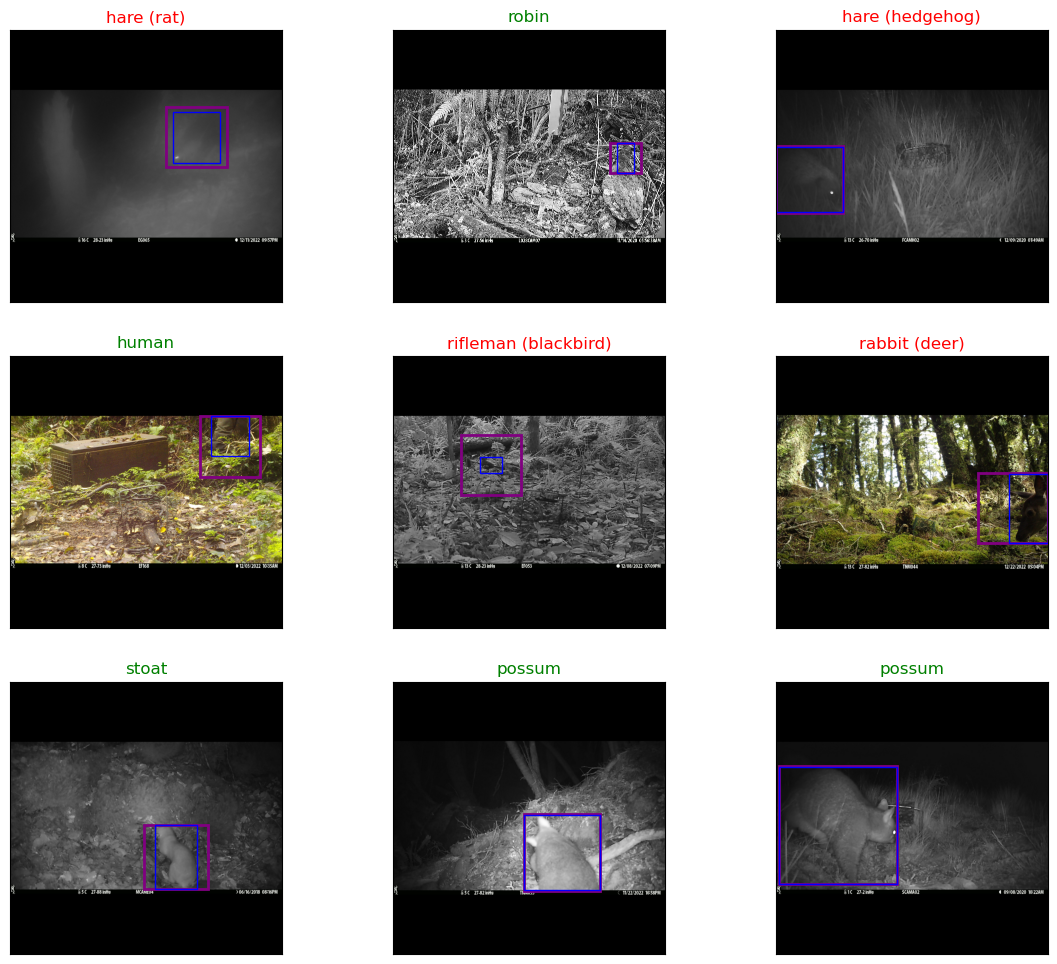

In [16]:
show_inferred_imgs(cleaned_inf_df, num_ims=9)

In [17]:
keepers = balance_data(cleaned_inf_df[['Targets']], str(independent_image_dir), 100, 400 )
cleaned_inf_df = cleaned_inf_df.loc[keepers]
print(f'Now there are {len(cleaned_inf_df)} rows in the dataframe')

Now there are 3915 rows in the dataframe


In [18]:
cleaned_inf_df.head()

,Date_Time,Encounter_Start,Encounter,Max_Prob,Targets,Prediction,Probability,Second_Pred,Second_Prob,Third_Pred,...,tui,wallaby,weasel,weka,white_faced_heron,whitehead,wrybill,yellow_eyed_penguin,yellowhammer,File_Path
Image_File_Paths,,,,,,,,,,,,,,,,,,,,,
e:\Project\Data\Independent_Images\ES1\banded_dotterel\627B570A-0739-4F2C-BB16-83C7404C197C.JPG,12/09/2020 10:38:27,10:38:27,banded_dotterel,0.984,banded_dotterel,banded_dotterel,0.984,tomtit,0.004,sparrow,...,0.0,0.0,0.000,0.000,0.0,0.0,0.002,0.0,0.000,e:\Project\Data\Independent_Images\ES1\banded_...
e:\Project\Data\Independent_Images\EM1\bellbird\A55B1B02-4420-47A3-B959-8DD46745D13F.JPG,14/06/2021 12:03:11,12:03:09,rifleman,0.336,bellbird,rifleman,0.336,robin,0.330,tomtit,...,0.0,0.0,0.003,0.015,0.0,0.0,0.000,0.0,0.000,e:\Project\Data\Independent_Images\EM1\bellbir...
e:\Project\Data\Independent_Images\N01\bellbird\613DB3F0-8856-4583-B488-5A41CE509AB1.JPG,23/12/2022 11:49:06,11:49:02,bellbird,0.616,bellbird,bellbird,0.616,tomtit,0.146,silvereye,...,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.000,e:\Project\Data\Independent_Images\N01\bellbir...
e:\Project\Data\Independent_Images\N01\bellbird\E4F10162-C6D4-4D12-AC74-2079A0A8D74C.JPG,29/11/2022 10:11:50,10:11:50,bellbird,0.718,bellbird,bellbird,0.718,dunnock,0.060,rifleman,...,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.007,e:\Project\Data\Independent_Images\N01\bellbir...
e:\Project\Data\Independent_Images\N01\bellbird\DEC60A68-B7FA-45A2-98D2-68853EC18B43.JPG,15/12/2022 16:40:09,16:40:09,bellbird,0.512,bellbird,bellbird,0.512,finch,0.242,tomtit,...,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.004,e:\Project\Data\Independent_Images\N01\bellbir...


In [19]:
inf_preds_df = cleaned_inf_df.iloc[:,18:]
inf_preds_df.head(3)

,banded_rail,bellbird,black_backed_gull,black_billed_gull,black_fronted_tern,blackbird,canada_goose,cat,chamois,cow,...,tui,wallaby,weasel,weka,white_faced_heron,whitehead,wrybill,yellow_eyed_penguin,yellowhammer,File_Path
Image_File_Paths,,,,,,,,,,,,,,,,,,,,,
e:\Project\Data\Independent_Images\ES1\banded_dotterel\627B570A-0739-4F2C-BB16-83C7404C197C.JPG,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.0,0.0,0.002,0.0,0.0,e:\Project\Data\Independent_Images\ES1\banded_...
e:\Project\Data\Independent_Images\EM1\bellbird\A55B1B02-4420-47A3-B959-8DD46745D13F.JPG,0.0,0.022,0.0,0.0,0.0,0.054,0.0,0.0,0.0,0.0,...,0.0,0.0,0.003,0.015,0.0,0.0,0.000,0.0,0.0,e:\Project\Data\Independent_Images\EM1\bellbir...
e:\Project\Data\Independent_Images\N01\bellbird\613DB3F0-8856-4583-B488-5A41CE509AB1.JPG,0.0,0.616,0.0,0.0,0.0,0.068,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,e:\Project\Data\Independent_Images\N01\bellbir...


The most useful figure for the end user is likely to be the balanced accuracy, on the Encounter column.

In [20]:
def get_encounter_metrics(df, min_samples=1):
    """Takes just one column of targets, one of predictions, so that it can be used with the encounter column"""
    df = df.copy()
    class_counts = df['Targets'].value_counts()
    mask = df['Targets'].isin(class_counts[class_counts > min_samples].index)
    df = df[mask]
    target_list = df['Targets'].to_list()
    encounter_list = df['Encounter'].to_list()
    prediction_list = df['Prediction'].to_list()
    warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")
    balanced_accuracy_pred = round(balanced_accuracy_score(target_list, prediction_list), 3)  
    balanced_accuracy_enc = round( balanced_accuracy_score(target_list, encounter_list), 3)
    balanced_f1_pred = round(skm.f1_score(target_list, prediction_list, average='macro', zero_division=np.nan), 3)  #[None, 'micro', 'macro', 'weighted']
    balanced_f1_enc = round(skm.f1_score(target_list, encounter_list, average='macro', zero_division=np.nan), 3)  #[None, 'micro', 'macro', 'weighted']
    warnings.resetwarnings()
    return balanced_accuracy_pred, balanced_accuracy_enc,  balanced_f1_pred, balanced_f1_enc

In [21]:
balanced_acc_img, balanced_acc_enc,  balanced_f1_img, balanced_f1_enc = get_encounter_metrics(cleaned_inf_df, min_samples=40)

print('Metrics for all classes in the independent set, by image')
print(Colour.S + 'Balanced Accuracy Score By Image:' + Colour.E, balanced_acc_img)
print(Colour.S + 'Balanced F1 Score by Image:' + Colour.E, balanced_f1_img, '\n')

print('Metrics for all classes in the independent set, by encounter')
print(Colour.S + 'Balanced Accuracy Score By Encounter:' + Colour.E, balanced_acc_enc)
print(Colour.S + 'Balanced F1 Score by Encounter:' + Colour.E, balanced_f1_enc)

Metrics for all classes in the independent set, by image
Balanced Accuracy Score By Image: 0.673
Balanced F1 Score by Image: 0.711 

Metrics for all classes in the independent set, by encounter
Balanced Accuracy Score By Encounter: 0.766
Balanced F1 Score by Encounter: 0.789


## Performance on Empties


In [22]:
empties_df, speed = Inference.main(settings_pth, external_image_dir=empty_image_dir)
cuda_data = torch.cuda.memory_allocated()
print(f'There is {cuda_data} Bytes allocated data left in the GPU memory after inference on the independent dataset')

json files found [WindowsPath('e:/Project/Data/Empty_Images/mdPredictions.json')]
The root path of the image folder is e:\Project\Data\Empty_Images
The dataframe length after processing e:\Project\Data\Empty_Images\mdPredictions.json: 561
['unknown']
Length of the labels dataframe: 561
                                           File_Path  Mega_Class  Confidence  \
0  e:\Project\Data\Empty_Images\defo\00749964-DE5...          -1      -1.000   
1  e:\Project\Data\Empty_Images\defo\00ED013D-EB1...           1       0.431   
2  e:\Project\Data\Empty_Images\defo\01BF7CB3-7C0...          -1      -1.000   

    x_min   y_min    Width  Height  Species Location  Targets  
0  0.0000  0.0000  1.00000  1.0000  unknown  unknown  unknown  
1  0.4475  0.9328  0.09895  0.0359  unknown  unknown  unknown  
2  0.0000  0.0000  1.00000  1.0000  unknown  unknown  unknown  
There are 1280 input features to the classifier head 80 outputs
Image Folder: e:\Project\Data\Empty_Images, (561 images)
Using torch 2.0

100%|██████████| 1/1 [00:00<00:00, 18.98it/s]

The dataframe saved to CSV


                                                              Date_Time  \
Image_File_Paths                                                          
e:\Project\Data\Empty_Images\defo\Adam_2018_1_C...  01/01/2011 00:00:23   
e:\Project\Data\Empty_Images\defo\Wayne_2016_1_...  05/01/2011 12:53:46   
e:\Project\Data\Empty_Images\defo\Graeme_2018_1...  27/01/2011 14:10:35   
e:\Project\Data\Empty_Images\defo\IMG_0006.JPG      16/01/2015 00:57:59   
e:\Project\Data\Empty_Images\defo\Wayne_2016_2_...  19/10/2015 15:18:55   

                                                   Encounter  Max_Prob  
Image_File_Paths                                                        
e:\Project\Data\Empty_Images\defo\Adam_2018_1_C...       cat     0.292  
e:\Project\Data\Empty_Images\defo\Wayne_2016_1_...     empty     0.000  
e:\Project\Data\Empty_Images\defo\Graeme_2018_1...     empty     0.000  
e:\Project\Data\Empty_Images\defo\IMG_0006.JPG         empty     0.000  
e:\Project\Data\Empty_Images\defo\Wa

In [23]:
empties_df['Targets']='empty'
empties_df.head()

,Date_Time,Encounter_Start,Encounter,Max_Prob,Targets,Prediction,Probability,Second_Pred,Second_Prob,Third_Pred,...,tui,wallaby,weasel,weka,white_faced_heron,whitehead,wrybill,yellow_eyed_penguin,yellowhammer,File_Path
Image_File_Paths,,,,,,,,,,,,,,,,,,,,,
e:\Project\Data\Empty_Images\defo\Adam_2018_1_Camera1_6__4401F40B-1730-409A-B9C7-2D062BD3E820.JPG,01/01/2011 00:00:23,00:00:23,cat,0.292,empty,cat,0.292,stoat,0.193,dunnock,...,0.0,0.002,0.008,0.001,0.0,0.0,0.0,0.000,0.000,e:\Project\Data\Empty_Images\defo\Adam_2018_1_...
e:\Project\Data\Empty_Images\defo\Wayne_2016_1_Camera1_4__2679B2F9-5B71-4069-8D46-B15CBD419AF2.JPG,05/01/2011 12:53:46,12:53:46,empty,0.000,empty,empty,0.000,empty,0.000,empty,...,0.0,0.001,0.001,0.036,0.0,0.0,0.0,0.001,0.001,e:\Project\Data\Empty_Images\defo\Wayne_2016_1...
e:\Project\Data\Empty_Images\defo\Graeme_2018_1_Camera1_9__9E65B835-EFFF-4187-B11D-B54B0E198AB4.JPG,27/01/2011 14:10:35,14:10:35,empty,0.000,empty,empty,0.000,empty,0.000,empty,...,0.0,0.001,0.000,0.003,0.0,0.0,0.0,0.000,0.000,e:\Project\Data\Empty_Images\defo\Graeme_2018_...
e:\Project\Data\Empty_Images\defo\IMG_0006.JPG,16/01/2015 00:57:59,00:57:59,empty,0.000,empty,empty,0.000,empty,0.000,empty,...,0.0,0.004,0.000,0.000,0.0,0.0,0.0,0.000,0.000,e:\Project\Data\Empty_Images\defo\IMG_0006.JPG
e:\Project\Data\Empty_Images\defo\Wayne_2016_2_Camera1_1__68B9653A-1B54-462B-A19C-BC5EDC3D184C.JPG,19/10/2015 15:18:55,15:18:55,empty,0.000,empty,empty,0.000,empty,0.000,empty,...,0.0,0.000,0.001,0.019,0.0,0.0,0.0,0.000,0.000,e:\Project\Data\Empty_Images\defo\Wayne_2016_2...


In [24]:
empties_df['Encounter'].value_counts()

Encounter
empty                516
cat                    7
possum                 5
rat                    5
stoat                  4
human                  3
dunnock                3
mouse                  3
finch                  3
blackbird              3
tomtit                 2
rifleman               1
starling               1
pipit                  1
pig                    1
black_billed_gull      1
fantail                1
hedgehog               1
Name: count, dtype: Int64

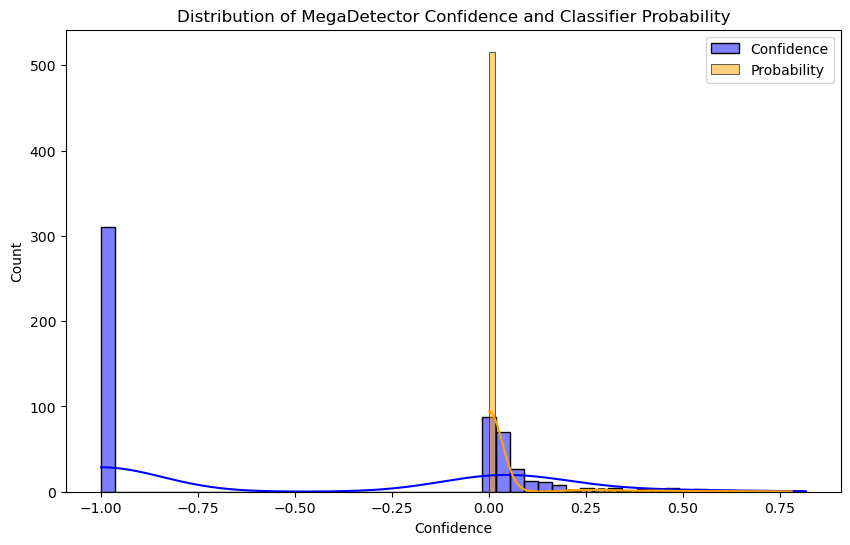

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=empties_df, x='Confidence',  bins=50, kde=True, label='Confidence', color='blue')
sns.histplot(data=empties_df, x='Probability',  bins=50, kde=True, label='Probability', color='orange')
plt.title('Distribution of MegaDetector Confidence and Classifier Probability')
plt.legend()
plt.show()

In [26]:
# Filter the DataFrame to keep only rows with at least 40 instances of each value in 'Target'
filtered_encounter_df = cleaned_inf_df.groupby('Targets').filter(lambda x: len(x) >= 40)

In [27]:
empty_count = (filtered_encounter_df['Encounter'] == 'empty').sum()
empty_count

45

In [28]:
filtered_encounter_df['Encounter'].unique()

<StringArray>
[    'blackbird',         'stoat',         'robin',         'mouse',
         'finch',      'rifleman',        'thrush',       'dunnock',
           'rat',          'weka',         'pipit',           'cat',
        'possum',         'empty',         'human',          'deer',
        'rabbit',          'kiwi',          'hare',      'bellbird',
           'cow',        'ferret',      'hedgehog',           'pig',
          'goat',         'sheep',           'kea',         'quail',
       'harrier',        'tomtit',        'kereru',     'silvereye',
  'shore_plover',          'myna', 'oystercatcher',        'weasel',
           'tui',       'sealion']
Length: 38, dtype: string

In [29]:
df = pd.concat([filtered_encounter_df.iloc[:, :8].copy(), empties_df.iloc[:, :8].copy()], ignore_index=True)
df.head()

,Date_Time,Encounter_Start,Encounter,Max_Prob,Targets,Prediction,Probability,Second_Pred
0,21/01/2023 07:00:59,07:00:59,blackbird,0.630,blackbird,blackbird,0.357,thrush
1,15/10/2020 05:45:30,05:45:29,blackbird,0.988,blackbird,blackbird,0.501,robin
2,09/09/2020 10:16:32,10:16:30,blackbird,0.930,blackbird,blackbird,0.549,thrush
3,11/11/2020 16:56:21,16:56:20,blackbird,1.000,blackbird,blackbird,1.000,robin
4,26/01/2023 17:54:15,17:54:11,blackbird,0.517,blackbird,blackbird,0.421,thrush


['bellbird', 'black_billed_gull', 'blackbird', 'cat', 'cow', 'deer', 'dunnock', 'empty', 'fantail', 'ferret', 'finch', 'goat', 'hare', 'harrier', 'hedgehog', 'human', 'kea', 'kereru', 'kiwi', 'mouse', 'myna', 'oystercatcher', 'pig', 'pipit', 'possum', 'quail', 'rabbit', 'rat', 'rifleman', 'robin', 'sealion', 'sheep', 'shore_plover', 'silvereye', 'starling', 'stoat', 'thrush', 'tomtit', 'tui', 'weasel', 'weka']


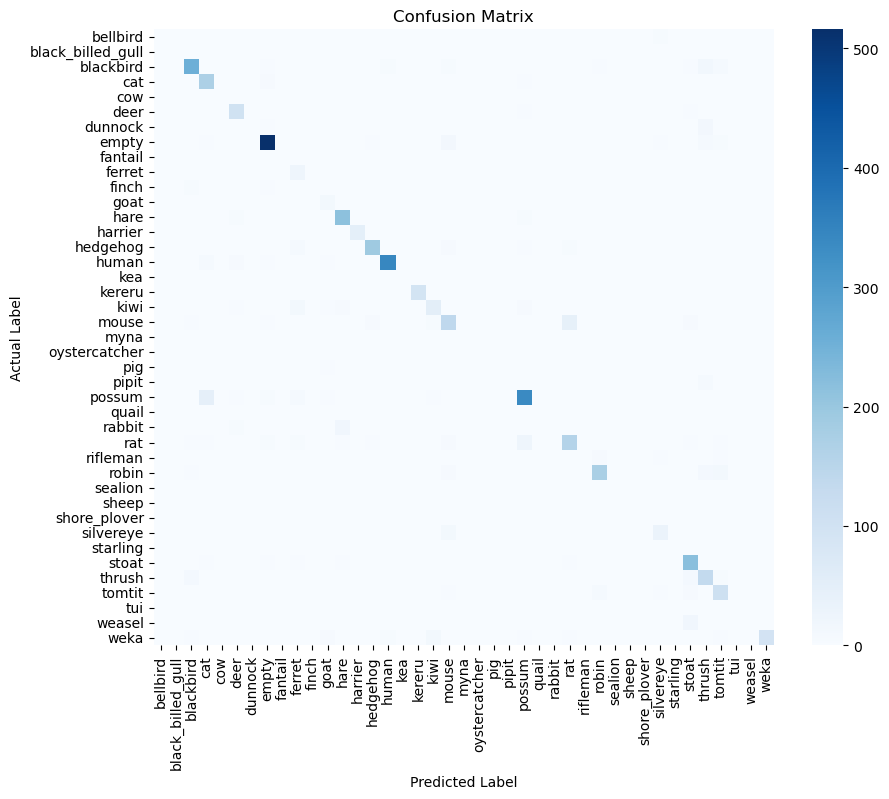

In [30]:
unique_labels_order = sorted(list(set(list(df['Targets'].unique()) + list(df['Encounter'].unique()))))
print(unique_labels_order)
conf_matrix = confusion_matrix(df['Encounter'], df['Targets'], labels=unique_labels_order)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=unique_labels_order, index=unique_labels_order)
conf_matrix_df.to_csv(cf_matrix_overall_pth)
plt.figure(figsize=(10, 8))
# Display the confusion matrix with label names
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=unique_labels_order, yticklabels=unique_labels_order)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
cleaned_inf_df['Targets'].value_counts()

Targets
possum             400
human              361
blackbird          293
stoat              287
hare               251
cat                238
rat                225
hedgehog           211
mouse              205
thrush             203
robin              203
tomtit             153
deer               132
weka               100
kereru              93
kiwi                77
ferret              66
harrier             49
silvereye           49
goat                41
paradise_duck       39
rabbit              35
pipit               35
pig                 34
yellowhammer        27
dunnock             24
fantail             20
rifleman            12
tui                  9
magpie               9
dog                  9
bellbird             7
cow                  7
morepork             6
kea                  3
weasel               1
banded_dotterel      1
Name: count, dtype: Int64

In [32]:
precision = precision_score(df['Targets'], df['Encounter'], average=None, labels=unique_labels_order, zero_division=1)
recall = recall_score( df['Targets'], df['Encounter'],  average=None, labels=unique_labels_order, zero_division=1)

targets = np.array( df['Targets'].to_list())
predictions = np.array(df['Encounter'].to_list())
bal_accuracy = balanced_accuracy_score(targets, predictions)

animals_of_interest = ['possum','empty', 'cat', 'stoat', 'ferret', 'hedgehog', 'mouse', 'rabit', 
                       'hare', 'kiwi', 'kereru', 'goat','deer', 'human', 'rat', 
                       'blackbird', 'robin', 'weka', 'harrier', 'paradise_duck']
target_counts = df['Targets'].value_counts()

print(Colour.S + f'The balanced accuracy score on this dataset is {bal_accuracy: .2f}' + Colour.E + "\n")
precs, recs = [], []
for label, prec, rec in zip(unique_labels_order, precision, recall):
    if label in animals_of_interest:
        count = target_counts.get(label, 0)  # Get the count for the current label
        precs.append(prec)
        recs.append(rec)
        print(f'{label}: Precision={prec:.2f}, Recall={rec:.2f}, Targets={count}')
        
print("\n" + Colour.S + f'The mean precision score for classes with more than 40 samples is: '  + Colour.E + f'{np.mean(precs):.2f}') 
print(Colour.S + f'The mean recall score for classes with more than 40 samples is: '  + Colour.E + f'{np.mean(recs):.2f}' + "\n")         


The balanced accuracy score on this dataset is  0.77

blackbird: Precision=0.83, Recall=0.87, Targets=293
cat: Precision=0.93, Recall=0.71, Targets=238
deer: Precision=0.92, Recall=0.77, Targets=132
empty: Precision=0.92, Recall=0.92, Targets=561
ferret: Precision=1.00, Recall=0.38, Targets=66
goat: Precision=1.00, Recall=0.34, Targets=41
hare: Precision=0.94, Recall=0.85, Targets=251
harrier: Precision=0.98, Recall=1.00, Targets=49
hedgehog: Precision=0.86, Recall=0.91, Targets=211
human: Precision=0.93, Recall=0.95, Targets=361
kereru: Precision=1.00, Recall=1.00, Targets=93
kiwi: Precision=0.59, Recall=0.70, Targets=77
mouse: Precision=0.64, Recall=0.68, Targets=205
possum: Precision=0.81, Recall=0.84, Targets=400
rat: Precision=0.70, Recall=0.70, Targets=225
robin: Precision=0.82, Recall=0.86, Targets=203
stoat: Precision=0.90, Recall=0.76, Targets=287
weka: Precision=0.67, Recall=0.95, Targets=100

The mean precision score for classes with more than 40 samples is: 0.86
The mean re

c:\Users\ollyp\miniconda3\envs\cv_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [33]:
predators = ['rat', 'stoat', 'possum', 'cat']
precisions, recalls = 0, 0
for label, prec, rec in zip(unique_labels_order, precision, recall):
    if label in predators:
        count = target_counts.get(label, 0)  # Get the count for the current label
        precisions += prec
        recalls += rec
mean_prec, mean_rec = precisions / 4, recalls / 4
print(f'Mean scores for predators, precision: {mean_prec:.2f} recall: {mean_rec:0.2f}')

Mean scores for predators, precision: 0.84 recall: 0.76


In [34]:
tp_empties = (empties_df['Encounter'] == 'empty').sum()
fp_empties = (filtered_encounter_df['Encounter'] == 'empty').sum()
tn_empties = len(filtered_encounter_df) - fp_empties
fn_empties = len(empties_df) - tp_empties

print(Colour.S + f'True Positive Empties: '  + Colour.E + f'{tp_empties}') 
print(Colour.S + f'False Positive Empties: '  + Colour.E + f'{fp_empties}')
print(Colour.S + f'True Negative Empties: '  + Colour.E + f'{tn_empties}')
print(Colour.S + f'False Negative Empties: '  + Colour.E + f'{fn_empties}' "\n")  

print(Colour.S + f'Empties Precision: '  + Colour.E + f'{tp_empties/(fp_empties + tp_empties):.2f}')
print(Colour.S + f'Empties Recall: '  + Colour.E + f'{tp_empties/(tp_empties + fn_empties):.2f}')   

True Positive Empties: 516
False Positive Empties: 45
True Negative Empties: 3592
False Negative Empties: 45

Empties Precision: 0.92
Empties Recall: 0.92


I got a big jump in performance by ensembling both models, and taking the sum of the Confidence < Max Probability => empty   Results shown here are all with the MD threshold and the classifier threshold equal values.

Experiment_26, Run_01, requiring Confidence < MD_THRESHOLD > AND Probability < THRESHOLD to re-assign the score to 'empty'
| **Thresholds** | **TP** | **FP** | **TN** |**FN** | **Empty Prec** | **Empty Recall** | **Bal Acc** | **Precision** |  **Recall**  |
:----:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 0.6 |  556  | 338  |  3299  |  5   |  0.62  |  0.99  |       |      |      |
| 0.5 |  550  | 242  |  3395  |  11  |  0.69  |  0.98  |       |      |      |
| 0.4 |  543  | 166  |  3471  |  18  |  0.77  |  0.97  |  0.76 |      |      |
| 0.3 |  535  | 108  |  3529  |  26  |  0.83  |  0.95  |  0.76 | 0.77 | 0.81 |
| 0.2 |  527  | 70   |  3567  |  34  |  0.88  |  0.94  |  0.77 | 0.78 | 0.81 | 
| 0.15|  516  | 43   | 3594   |  45  |  0.92  |  0.92  |  0.78 |  0.78| 0.81 |  
| 0.1 |  500  | 29   | 3608   |  61  |  0.94  |  0.89  | 0.76  | 0.81  | 0.78|

For the whole of dataset metrics, reporting the mean over each class for all the classes with more than 40 samples:
- Precision  = tp / (tp + fp): For each class, the chance of getting this class right if it is predicted
- Recall = tp / (tp + fn):   The chance of getting this class right if it is true  
- Accuracy  = tp / Total:  The overall chance of a prediction in this class being correct  
The TP, FP, TN, FN, Empty Prec, Empty recall  colums refer to the score only for the empty class.